In [2]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import pickle
import seaborn as sns


plt.rcParams['font.size'] = 14

In [8]:
def read_times(log_path):
    with open(log_path, 'r') as f:
        lines = f.readlines()
    res = {}
    for line in lines:
        key, val = line.split(':')
        key, val  = int(key), float(re.findall(r'\d+\.\d+',val)[0])
        res[key] = val
        # if key in res:
        #     res[key].append(val)
        # else:
        #     res[key] = [val]
    return res
    
# cvode_nrn_runs = read_times('/global/cscratch1/sd/zladd/NeuroGPU/ForZ/seed_figure/python/cvode_neuron_times')
# neuron_runs = read_times('/global/cscratch1/sd/zladd/NeuroGPU/ForZ/seed_figure/python/neuron_times')
cvode_nrn_runs = read_times('python/neuron_adaptive')
neuron_runs = read_times('python/neuron_fixed_pop')
core_nrn_runs = read_times('python/coreNeuron_times')
neurogpu_runs = read_times('python/neuroGPU_times')


In [9]:
print(neurogpu_runs)



def split_run_stats(runs):
    all_vals = []
    for i in range(3,7):
        all_vals.append(runs[i])
    front_mean, front_std = np.mean(all_vals), np.std(all_vals)
    for i in range(145,149):
        all_vals.append(runs[i])
    end_mean, end_std = np.mean(all_vals), np.std(all_vals)
    return front_mean, front_std, end_mean, end_std



{3: 6.881296396255493, 4: 6.675385475158691, 5: 6.719912528991699, 6: 6.6590447425842285, 145: 6.828293561935425, 146: 6.752049207687378, 147: 6.705164670944214, 148: 6.54436469078064, 149: 6.732197284698486}


In [10]:

def plot_runs(runs,ax,shift=0, label=None, color='black'):
    split0, split1 = 1+shift,10+shift
    mean1, s1, mean2, s2 = split_run_stats(runs)
    if label == 'NEURON \n adaptive \n integration':
        bar = ax.bar([split0,split1],[mean1, mean2] , yerr=[s1,s2], label=label, color=color, hatch='/', edgecolor='black', linewidth=1.5)
    else:
        bar = ax.bar([split0,split1],[mean1, mean2] , yerr=[s1,s2], label=label, color=color, edgecolor='black', linewidth=1.5)
    
    ax.bar_label(bar, fmt="%i")

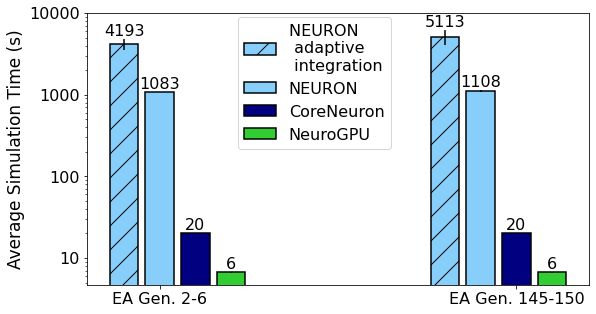

In [17]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(9,5))
ax = fig.gca()
plot_runs(cvode_nrn_runs,ax,shift=0,label='NEURON \n adaptive \n integration', color='lightskyblue')
plot_runs(neuron_runs,ax,shift=1,label='NEURON', color='lightskyblue')

plot_runs(core_nrn_runs,ax,shift=2, label='CoreNeuron', color='navy')
plot_runs(neurogpu_runs,ax,shift=3, label='NeuroGPU', color='limegreen')
plt.legend(loc=(.3,.5))
plt.yscale('log')
ax.set_ylim(top=10000)

from matplotlib.ticker import ScalarFormatter
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
    
ax.set_xticks([2,12])
ax.set_xticklabels(['EA Gen. 2-6', 'EA Gen. 145-150'])
plt.ylabel('Average Simulation Time (s)', fontsize=17)
fig.savefig('sim_time', bbox_inches='tight', facecolor='white', dpi=600)

# BoxPlot Fig

In [68]:
gens = [2,3,4,5,6,145,146,147,148,149]
with open('python/neuron_fixed_indvs','r') as f:
    lines = f.readlines()
neuron_times = np.array([float(line.replace(' \n','')) for line in lines]).reshape(-1,10).T
neuron_times = {gens[i]: neuron_times[i] for i in range(10)}
data = neuron_times 

with open('python/neuron_times_adaptive','r') as f:
    lines = f.readlines()
cvode_times = np.array([float(line.replace(' \n','')) for line in lines]).reshape(-1,10).T
cvode_times = {gens[i]: cvode_times[i] for i in range(10)}
data2 = cvode_times 

(array([297., 233., 268., 154.,  29.,  11.,   3.,   2.,   2.,   1.]),
 array([  10.00305223,  175.41447449,  340.82589674,  506.23731899,
         671.64874125,  837.0601635 , 1002.47158575, 1167.883008  ,
        1333.29443026, 1498.70585251, 1664.11727476]),
 <BarContainer object of 10 artists>)

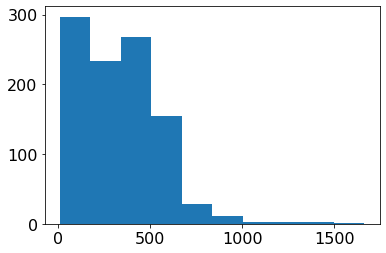

In [81]:
plt.hist(data2[2])

In [69]:
df = pd.DataFrame.from_dict(data)
df['setting'] = 'NEURON'


df2 = pd.DataFrame.from_dict(data2)
df2['setting'] = 'NEURON \n adaptive \n integration'


cat_df = pd.concat([df,df2])

In [70]:
df = cat_df.melt(['setting'])

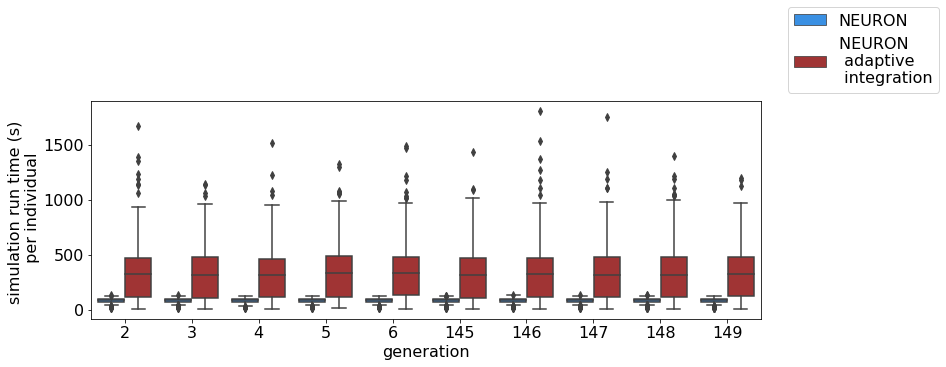

In [78]:
# plt.scatter(np.arange(len(data[148])),data[148])
fig = plt.figure(figsize=(12,4))
df = df.rename({'variable':'generation',"value": "simulation run time (s) \n per individual"}, axis=1)
sns.boxplot(x='generation',y='simulation run time (s) \n per individual',data=df, hue='setting', showfliers=True, orient='v', palette=['dodgerblue','firebrick'])
plt.legend(loc=(1.04,1.04))

plt.savefig('distribution.png', bbox_inches='tight', dpi=600)
# plt.close(fig)

In [22]:
# np.savetxt('/global/cscratch1/sd/zladd/NeuroGPU/ForZ/seed_figure/Data/Stim_raw0.csv', stim[::2], delimiter=',')